#### Virus × EVE's classification

___Inference___


Imports

In [1]:
import pandas as pd

#### Parameters

In [2]:
col_class_eve = 'class'
col_class_dark = 'Similarity_label'
col_id_dark = 'Contigs_ID'

In [3]:
x_range_eve = list(range(4, 52))
x_range_dark = list(range(2, 51))

In [4]:
''' 
    TODO: 2023-06-17 - Find a better way to to this...
''' 
feat_eves = [
    'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24',
    'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34',
    'X35', 'X.15', 'X.16', 'X.17', 'X.18', 'X.19', 'X.20', 'X.21', 'X.22',
    'X.23', 'X.24', 'X.25', 'X.26', 'X.27', 'X.28', 'X.29', 'X.30', 'X.31',
    'X.32', 'X.33', 'X.34', 'X.35', 'dens15to18', 'dens20to22',
    'dens25to29', 'ratiosi_pi', 'ratio_si', 'dens18to35'
]

In [5]:
path_root = './'

path_classifier = f'{path_root}/model_classifier_rf.pkl'
path_runs = f'{path_root}/runs'

path_feat = lambda path_dir: f'{path_dir}/Zscore_and_features_matrix.tab'
path_summary = lambda path_dir: f'{path_dir}/summary.yml'


In [6]:
path_dicer2 = f'{path_runs}/dicer2/'
path_r2d2 = f'{path_runs}/r2d2/'

libs = [
    
    # dicer 2
    { 'id': 'RNPM68_01',    'server': 'dicer2', 'dir': f'{path_dicer2}/exec_RNPM68_01' },
    { 'id': 'RNPM164_01',   'server': 'dicer2', 'dir': f'{path_dicer2}/exec_RNPM164_01' },
    { 'id': 'RNPM221_01',   'server': 'dicer2', 'dir': f'{path_dicer2}/exec_RNPM221_01' },
    { 'id': 'RKPM44_06',    'server': 'dicer2', 'dir': f'{path_dicer2}/exec_test_v2_06' },
    { 'id': 'ZIKV_01',      'server': 'dicer2', 'dir': f'{path_dicer2}/exec_ZIKV_01' },
    
    # r2d2
    { 'id': 'RNPM2_02',     'server': 'r2d2', 'dir': f'{path_r2d2}/RNPM2_02' },
    { 'id': 'RNPM110_02',   'server': 'r2d2', 'dir': f'{path_r2d2}/RNPM110_02' },
    { 'id': 'RNPM169_01',   'server': 'r2d2', 'dir': f'{path_r2d2}/RNPM169_01' },
    { 'id': 'RNPM170_01',   'server': 'r2d2', 'dir': f'{path_r2d2}/RNPM170_01' },
]

## Classify Dark Matter DB sequences

In [7]:
import yaml
from inference import get_classification_report

In [8]:
df_report = pd.DataFrame(
    # columns = [
    #     'id',
    #     'input_size', 'n_reads',
    #     'n_contigs', 'n_contigs_gt_200',
    #     'output_size',
    #     'pipe_viral', 'pipe_non_viral', 'pipe_no_hit',
    #     'viral_viral', 'viral_eve',
    #     'nonviral_viral', 'nonviral_eve',
    #     'nohit_viral', 'nohit_eve',
    # ]
    columns = [
        'ID',
        'Reads',
        'Contigs', 'Contigs >= 200nt',
        'viral', 'nonviral', 'nohit',
        'viral [viral]', 'viral [eve]',
        'nonviral [viral]', 'nonviral [eve]',
        'nohit [viral]', 'nohit [eve]',
        'Input Size',
        'Output Size',
        'Running Time'
    ]
)

In [9]:


for lib in libs:
    
    # Run virus × EVE classification
    path_lib = path_feat(lib.get('dir'))
    df_dark = pd.read_table(path_lib)
    
    df_classification = get_classification_report(
        df_dark=df_dark, path_classifier=path_classifier,
        feat_eves=feat_eves, x_range_dark=x_range_dark,
        col_class_dark=col_class_dark, col_class_eve=col_class_eve, col_id_dark=col_id_dark,
    )
    
    # Build lib summary
    pipe_class_group = df_dark.groupby(col_class_dark)[col_class_dark].value_counts()
    
    with open(path_summary(lib.get('dir')), 'r') as file:
        pipe_summary = yaml.safe_load(file)

    class_match = lambda class_dark, class_eve: \
        df_classification[ (df_classification[col_class_dark] == class_dark) & (df_classification[col_class_eve] == class_eve)]

    df_row = pd.DataFrame(
        # {
        #     'id': lib['id'],
        #     'input_size': pipe_summary.get('input_size'),
        #     'n_reads': pipe_summary.get('n_reads'),
        #     'n_contigs': pipe_summary.get('n_contigs'),
        #     'n_contigs_gt_200': pipe_summary.get('n_contigs_gt_200'),
        #     'output_size': pipe_summary.get('output_size'),
        #     'pipe_viral': int(pipe_class_group['viral'].values),
        #     'pipe_non_viral': int(pipe_class_group['nonviral'].values),
        #     'pipe_no_hit': int(pipe_class_group['nohit'].values),
        #     'viral_viral': class_match('viral', 'viral').shape[0],
        #     'viral_eve': class_match('viral', 'eve').shape[0],
        #     'nonviral_viral': class_match('nonviral', 'viral').shape[0],
        #     'nonviral_eve': class_match('nonviral', 'eve').shape[0],
        #     'nohit_viral': class_match('nohit', 'viral').shape[0],
        #     'nohit_eve': class_match('nohit', 'eve').shape[0],
        # },
        {
            'ID': lib['id'],
            'Reads': pipe_summary.get('n_reads'),
            'Contigs': pipe_summary.get('n_contigs'),
            'Contigs >= 200nt': pipe_summary.get('n_contigs_gt_200'),
            'viral': int(pipe_class_group['viral'].values),
            'nonviral': int(pipe_class_group['nonviral'].values),
            'nohit': int(pipe_class_group['nohit'].values),
            'viral [viral]': class_match('viral', 'viral').shape[0],
            'viral [eve]': class_match('viral', 'eve').shape[0],
            'nonviral [viral]': class_match('nonviral', 'viral').shape[0],
            'nonviral [eve]': class_match('nonviral', 'eve').shape[0],
            'nohit [viral]': class_match('nohit', 'viral').shape[0],
            'nohit [eve]': class_match('nohit', 'eve').shape[0],
            'Input Size': pipe_summary.get('input_size'),
            'Output Size': pipe_summary.get('output_size'),
            'Running Time': pipe_summary.get('time'),
            'Server': lib['server'],
        },
        index=[0]
    )

    # Add this lib parsing to report
    df_report = pd.concat([df_report, df_row], ignore_index=True)
    
    lib['df_classification'] = df_classification.copy()
    lib['pipe_summary'] = pipe_summary


### Tables

In [10]:
df_report

,ID,Reads,Contigs,Contigs >= 200nt,viral,nonviral,nohit,viral [viral],viral [eve],nonviral [viral],nonviral [eve],nohit [viral],nohit [eve],Input Size,Output Size,Running Time,Server
0,RNPM68_01,13125926,1247,19,2,12,5,1,1,0,12,0,5,1037244,25688,02:43:15:146,dicer2
1,RNPM164_01,44565086,2138,44,42,24,14,40,2,0,24,0,14,3446536,383912,03:43:50:482,dicer2
2,RNPM221_01,20062770,3560,379,20,297,62,11,9,23,274,4,58,1628196,1010548,05:39:36:411,dicer2
3,RKPM44_06,21595029,1991,73,25,21,26,23,2,0,21,0,26,1712048,433872,13:17:46:144,dicer2
4,ZIKV_01,33757362,12837,742,66,346,330,36,30,99,247,93,237,1880184,576372,09:28:07:815,dicer2
5,RNPM2_02,15102630,19160,1274,61,270,943,5,56,24,246,64,879,1225448,139764,15:26:14:736,r2d2
6,RNPM110_02,20421283,5562,271,47,73,151,17,30,4,69,1,150,1623392,90044,05:20:44:031,r2d2
7,RNPM169_01,19663205,1716,49,24,18,7,22,2,2,16,0,7,1555264,30184,02:36:24:331,r2d2
8,RNPM170_01,24518179,3166,80,42,24,14,40,2,0,24,0,14,1913092,129756,02:57:24:567,r2d2


In [11]:

bytes_2_kb = lambda size_bytes: size_bytes / (1024)
bytes_2_mb = lambda size_bytes: size_bytes / (1024 * 1024)
bytes_2_gb = lambda size_bytes: size_bytes / (1024 * 1024 * 1024)

bytes_2_gb_str = lambda size_bytes: "{:.2f} GB".format(bytes_2_gb(size_bytes))
bytes_2_mb_str = lambda size_bytes: "{:.2f} MB".format(bytes_2_mb(size_bytes))
bytes_2_kb_str = lambda size_bytes: "{:.2f} KB".format(bytes_2_kb(size_bytes))

In [12]:
df_report2 = df_report.copy()

col_input = 'Input Size'
df_report2[f'{col_input} [GB]'] = df_report2[col_input].apply(bytes_2_gb_str)
df_report2[f'{col_input} [MB]'] = df_report2[col_input].apply(bytes_2_mb_str)
df_report2[f'{col_input} [KB]'] = df_report2[col_input].apply(bytes_2_kb_str)

col_output = 'Output Size'
df_report2[f'{col_output} [GB]'] = df_report2[col_output].apply(bytes_2_gb_str)
df_report2[f'{col_output} [MB]'] = df_report2[col_output].apply(bytes_2_mb_str)
df_report2[f'{col_output} [KB]'] = df_report2[col_output].apply(bytes_2_kb_str)

# mask_thousands = lambda x: "{:,.0f}".format(x)
mask_thousands = lambda x: "{:.2f}".format(x / 1000)
mask_million = lambda x: "{:.2f}".format(x / 1000 / 1000)

col_reads = 'Reads'
df_report2[f'{col_reads} [×10^3]'] = df_report2[col_reads].apply(mask_thousands)
df_report2[f'{col_reads} [×10^6]'] = df_report2[col_reads].apply(mask_million)
df_report2

,ID,Reads,Contigs,Contigs >= 200nt,viral,nonviral,nohit,viral [viral],viral [eve],nonviral [viral],...,Running Time,Server,Input Size [GB],Input Size [MB],Input Size [KB],Output Size [GB],Output Size [MB],Output Size [KB],Reads [×10^3],Reads [×10^6]
0,RNPM68_01,13125926,1247,19,2,12,5,1,1,0,...,02:43:15:146,dicer2,0.00 GB,0.99 MB,1012.93 KB,0.00 GB,0.02 MB,25.09 KB,13125.93,13.13
1,RNPM164_01,44565086,2138,44,42,24,14,40,2,0,...,03:43:50:482,dicer2,0.00 GB,3.29 MB,3365.76 KB,0.00 GB,0.37 MB,374.91 KB,44565.09,44.57
2,RNPM221_01,20062770,3560,379,20,297,62,11,9,23,...,05:39:36:411,dicer2,0.00 GB,1.55 MB,1590.04 KB,0.00 GB,0.96 MB,986.86 KB,20062.77,20.06
3,RKPM44_06,21595029,1991,73,25,21,26,23,2,0,...,13:17:46:144,dicer2,0.00 GB,1.63 MB,1671.92 KB,0.00 GB,0.41 MB,423.70 KB,21595.03,21.60
4,ZIKV_01,33757362,12837,742,66,346,330,36,30,99,...,09:28:07:815,dicer2,0.00 GB,1.79 MB,1836.12 KB,0.00 GB,0.55 MB,562.86 KB,33757.36,33.76
5,RNPM2_02,15102630,19160,1274,61,270,943,5,56,24,...,15:26:14:736,r2d2,0.00 GB,1.17 MB,1196.73 KB,0.00 GB,0.13 MB,136.49 KB,15102.63,15.10
6,RNPM110_02,20421283,5562,271,47,73,151,17,30,4,...,05:20:44:031,r2d2,0.00 GB,1.55 MB,1585.34 KB,0.00 GB,0.09 MB,87.93 KB,20421.28,20.42
7,RNPM169_01,19663205,1716,49,24,18,7,22,2,2,...,02:36:24:331,r2d2,0.00 GB,1.48 MB,1518.81 KB,0.00 GB,0.03 MB,29.48 KB,19663.21,19.66
8,RNPM170_01,24518179,3166,80,42,24,14,40,2,0,...,02:57:24:567,r2d2,0.00 GB,1.82 MB,1868.25 KB,0.00 GB,0.12 MB,126.71 KB,24518.18,24.52


In [13]:
cols_print = [
    'ID',
    'Reads [×10^6]',
    'Contigs', 'Contigs >= 200nt',
    # 'viral', 'nonviral', 'nohit',
    'Input Size [KB]',
    'Output Size [KB]',
    'Running Time',
    'Server',
]

df_report3 = df_report2[cols_print].copy()

foo = lambda x: x*'-'
baz = f'{foo(31)}'
print(f'--  {baz} Summary 01: Library sizes view  {baz}')

df_report3

--  ------------------------------- Summary 01: Library sizes view  -------------------------------


,ID,Reads [×10^6],Contigs,Contigs >= 200nt,Input Size [KB],Output Size [KB],Running Time,Server
0,RNPM68_01,13.13,1247,19,1012.93 KB,25.09 KB,02:43:15:146,dicer2
1,RNPM164_01,44.57,2138,44,3365.76 KB,374.91 KB,03:43:50:482,dicer2
2,RNPM221_01,20.06,3560,379,1590.04 KB,986.86 KB,05:39:36:411,dicer2
3,RKPM44_06,21.60,1991,73,1671.92 KB,423.70 KB,13:17:46:144,dicer2
4,ZIKV_01,33.76,12837,742,1836.12 KB,562.86 KB,09:28:07:815,dicer2
5,RNPM2_02,15.10,19160,1274,1196.73 KB,136.49 KB,15:26:14:736,r2d2
6,RNPM110_02,20.42,5562,271,1585.34 KB,87.93 KB,05:20:44:031,r2d2
7,RNPM169_01,19.66,1716,49,1518.81 KB,29.48 KB,02:36:24:331,r2d2
8,RNPM170_01,24.52,3166,80,1868.25 KB,126.71 KB,02:57:24:567,r2d2


In [14]:

cols_print = [
    'ID',
    'Reads [×10^6]',
    'Contigs', 
    'Contigs >= 200nt',
    'viral', 'nonviral', 'nohit',
    # 'viral [viral]', 'viral [eve]',
    # 'nonviral [viral]', 'nonviral [eve]',
    # 'nohit [viral]', 'nohit [eve]',
    # 'Input Size',
    # 'Output Size',
    # 'Running Time'
]

df_report4 = df_report2[cols_print].copy()

foo = lambda x: x*'-'
baz = f'{foo(12)}'
print(f'--  {baz} Summary 02: Pipeline classification view  {baz}')

df_report4

--  ------------ Summary 02: Pipeline classification view  ------------


,ID,Reads [×10^6],Contigs,Contigs >= 200nt,viral,nonviral,nohit
0,RNPM68_01,13.13,1247,19,2,12,5
1,RNPM164_01,44.57,2138,44,42,24,14
2,RNPM221_01,20.06,3560,379,20,297,62
3,RKPM44_06,21.60,1991,73,25,21,26
4,ZIKV_01,33.76,12837,742,66,346,330
5,RNPM2_02,15.10,19160,1274,61,270,943
6,RNPM110_02,20.42,5562,271,47,73,151
7,RNPM169_01,19.66,1716,49,24,18,7
8,RNPM170_01,24.52,3166,80,42,24,14


In [15]:

cols_print = [
    'ID',
    # 'Reads [×10^6]',
    # 'Contigs', 
    # 'Contigs >= 200nt',
    'viral', 'nonviral', 'nohit',
    'viral [viral]', 'viral [eve]',
    'nonviral [viral]', 'nonviral [eve]',
    'nohit [viral]', 'nohit [eve]',
    # 'Input Size',
    # 'Output Size',
    # 'Running Time'
]

df_report5 = df_report2[cols_print].copy()

foo = lambda x: x*'-'
baz = f'{foo(18)}'
print(f'--  {baz} Summary 03: Pipeline × Classifier classifications comparison  {baz}')

df_report5

--  ------------------ Summary 03: Pipeline × Classifier classifications comparison  ------------------


,ID,viral,nonviral,nohit,viral [viral],viral [eve],nonviral [viral],nonviral [eve],nohit [viral],nohit [eve]
0,RNPM68_01,2,12,5,1,1,0,12,0,5
1,RNPM164_01,42,24,14,40,2,0,24,0,14
2,RNPM221_01,20,297,62,11,9,23,274,4,58
3,RKPM44_06,25,21,26,23,2,0,21,0,26
4,ZIKV_01,66,346,330,36,30,99,247,93,237
5,RNPM2_02,61,270,943,5,56,24,246,64,879
6,RNPM110_02,47,73,151,17,30,4,69,1,150
7,RNPM169_01,24,18,7,22,2,2,16,0,7
8,RNPM170_01,42,24,14,40,2,0,24,0,14


In [16]:

# ID	viral	nonviral	nohit	viral [viral]	viral [eve]	nonviral [viral]	nonviral [eve]	nohit [viral]	nohit [eve]

# 0	RNPM68_01	2	12	5	1	1	                0	12	0	5
# 1	RNPM164_01	42	24	14	40	2	                0	24	0	14
# 3	RKPM44_06	25	21	26	23	2	                0	21	0	26
# 8	RNPM170_01	42	24	14	40	2	                0	24	0	14

# 7	RNPM169_01	24	18	7	22	2	                2	16	0	7
# 6	RNPM110_02	47	73	151	17	30	                4	69	1	150
# 5	RNPM2_02	61	270	943	5	56	                24	246	64	879

# 2	RNPM221_01	20	297	62	11	9	                23	274	4	58
# 4	ZIKV_01	66	346	330	36	30	                    99  247	93	237



# RNPM68_01, RNPM164_01, RKPM44_06, RNPM170_01

df_pumba = df_report5.copy()
df_pumba['nv_v %'] = 100 * (df_pumba['nonviral [viral]'] / df_pumba['nonviral [eve]'])
df_pumba['nh_v %'] = 100 * (df_pumba['nohit [viral]'] / df_pumba['nohit [eve]'])

df_pumba['foo %'] = 100 * (df_pumba['nonviral [viral]'] + df_pumba['nohit [viral]']) / (df_pumba['nonviral [eve]'] + df_pumba['nohit [eve]'])
df_pumba.sort_values(by=['foo %'])


# RNPM68_01, RNPM164_01, RKPM44_06, RNPM170_01
# RNPM110_02, RNPM221_01, RNPM2_02


# 0	RNPM68_01	2	12	5	1	1	        0	12	0	5	0.0
# 1	RNPM164_01	42	24	14	40	2	        0	24	0	14	0.0
# 3	RKPM44_06	25	21	26	23	2	        0	21	0	26	0.0
# 8	RNPM170_01	42	24	14	40	2	        0	24	0	14	0.0

# 6	RNPM110_02	47	73	151	17	30	        4	69	1	150	5.797101
# 2	RNPM221_01	20	297	62	11	9	        23	274	4	58	8.394161
# 5	RNPM2_02	61	270	943	5	56	        24	246	64	879	9.756098

# 7	RNPM169_01	24	18	7	22	2	        2	16	0	7	12.5
# 4	ZIKV_01	66	346	330	36	30	            99	247	93	237	40.080972

,ID,viral,nonviral,nohit,viral [viral],viral [eve],nonviral [viral],nonviral [eve],nohit [viral],nohit [eve],nv_v %,nh_v %,foo %
0,RNPM68_01,2,12,5,1,1,0,12,0,5,0.0,0.0,0.0
1,RNPM164_01,42,24,14,40,2,0,24,0,14,0.0,0.0,0.0
3,RKPM44_06,25,21,26,23,2,0,21,0,26,0.0,0.0,0.0
8,RNPM170_01,42,24,14,40,2,0,24,0,14,0.0,0.0,0.0
6,RNPM110_02,47,73,151,17,30,4,69,1,150,5.797101,0.666667,2.283105
5,RNPM2_02,61,270,943,5,56,24,246,64,879,9.756098,7.281001,7.822222
2,RNPM221_01,20,297,62,11,9,23,274,4,58,8.394161,6.896552,8.13253
7,RNPM169_01,24,18,7,22,2,2,16,0,7,12.5,0.0,8.695652
4,ZIKV_01,66,346,330,36,30,99,247,93,237,40.080972,39.240506,39.669421


In [17]:
from datetime import datetime

def time_str_2_hours(time_str: str) -> int:
    time_format = '%H:%M:%S:%f'
    time_obj = datetime.strptime(time_str, time_format)
    n_hours = (time_obj.microsecond / 1000000 + time_obj.second + time_obj.minute * 60 + time_obj.hour * 3600) / 3600
    return n_hours

In [18]:

cols_print = [
    'ID',
    'Reads',
    'Reads [×10^6]',
    # 'Contigs', 
    # 'Contigs >= 200nt',
    # 'viral', 'nonviral', 'nohit',
    # 'viral [viral]', 'viral [eve]',
    # 'nonviral [viral]', 'nonviral [eve]',
    # 'nohit [viral]', 'nohit [eve]',
    # 'Input Size',
    # 'Output Size',
    'Running Time',
    'Server',
]

df_report6 = df_report2[cols_print].copy()
df_report6['Running Hours'] = df_report6['Running Time'].apply(time_str_2_hours)

# df_report6[ ['Reads', 'Running Hours'] ].sort_values(by=['Running Hours'])
df_report6.sort_values(by=['Running Hours'])

# foo = lambda x: x*'-'
# baz = f'{foo(18)}'
# print(f'--  {baz} Summary 03: Pipeline × Classifier classifications comparison  {baz}')

# df_report6

,ID,Reads,Reads [×10^6],Running Time,Server,Running Hours
7,RNPM169_01,19663205,19.66,02:36:24:331,r2d2,2.606759
0,RNPM68_01,13125926,13.13,02:43:15:146,dicer2,2.720874
8,RNPM170_01,24518179,24.52,02:57:24:567,r2d2,2.956824
1,RNPM164_01,44565086,44.57,03:43:50:482,dicer2,3.730689
6,RNPM110_02,20421283,20.42,05:20:44:031,r2d2,5.345564
2,RNPM221_01,20062770,20.06,05:39:36:411,dicer2,5.660114
4,ZIKV_01,33757362,33.76,09:28:07:815,dicer2,9.468838
3,RKPM44_06,21595029,21.60,13:17:46:144,dicer2,13.296151
5,RNPM2_02,15102630,15.10,15:26:14:736,r2d2,15.437427


### Graphs

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

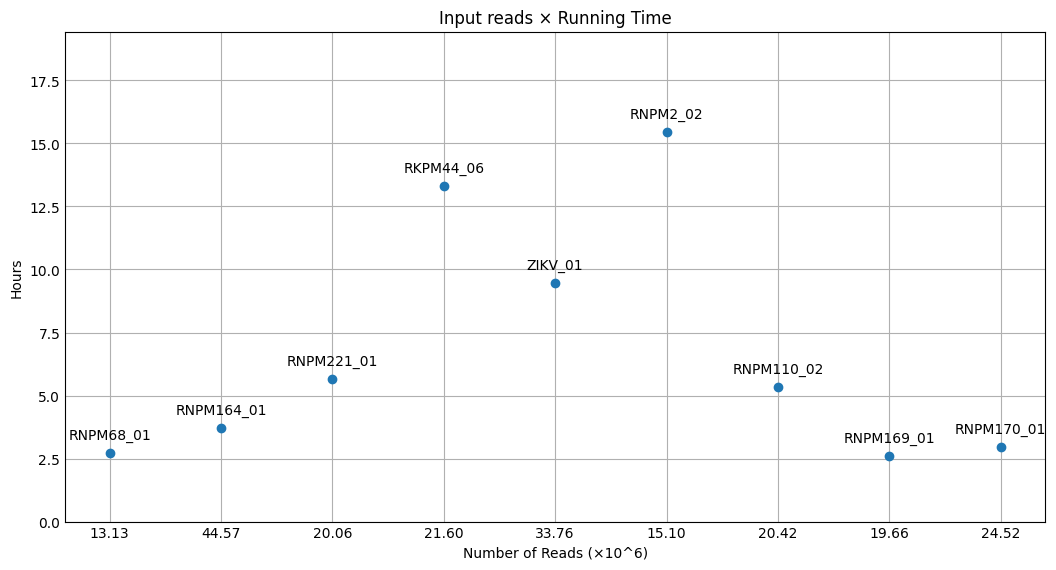

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# plot
fig, ax = plt.subplots(figsize=(10, 5))

x = df_report6['Reads [×10^6]']
y = df_report6['Running Hours']

ax.scatter(x, y)

max_time = 0
for i in range(df_report6.shape[0]):
    row = df_report6.iloc[i]

    if y[i] > max_time:
        max_time = y[i]
    ax.annotate(row['ID'], (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')

ax.set(
    # xlim=(0, 20), xticks=np.arange(1, 18),
    # xlim=(0, 20), xticks=np.arange(1, 18),
    # ylim=(0, 8), yticks=np.arange(1, 8))
    ylim=(0, max_time + 4),
    # yticks=np.arange(1, 8)
    xlabel='Number of Reads (×10^6)',
    ylabel='Hours',
)

ax.set_title('Input reads × Running Time')
plt.show()

In [39]:
66+346+	330

742

In [14]:
import plotly.graph_objects as go

fig =go.Figure(go.Sunburst(
    labels=["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parents=["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve" ],
    values=[10, 14, 12, 10, 2, 6, 6, 4, 4],
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

# labels = ['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen']
# values = [4500, 2500, 1053, 500]

# # pull is given as a fraction of the pie radius
# fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0.2, 0])])
# fig.show()


In [49]:
?go.Sunburst

Init signature:
go.Sunburst(
    arg=None,
    branchvalues=None,
    count=None,
    customdata=None,
    customdatasrc=None,
    domain=None,
    hoverinfo=None,
    hoverinfosrc=None,
    hoverlabel=None,
    hovertemplate=None,
    hovertemplatesrc=None,
    hovertext=None,
    hovertextsrc=None,
    ids=None,
    idssrc=None,
    insidetextfont=None,
    insidetextorientation=None,
    labels=None,
    labelssrc=None,
    leaf=None,
    legendgrouptitle=None,
    legendrank=None,
    legendwidth=None,
    level=None,
    marker=None,
    maxdepth=None,
    meta=None,
    metasrc=None,
    name=None,
    opacity=None,
    outsidetextfont=None,
    parents=None,
    parentssrc=None,
    root=None,
    rotation=None,
    sort=None,
    stream=None,
    text=None,
    textfont=None,
    textinfo=None,
    textsrc=None,
    texttemplate=None,
    texttemplatesrc=None,
    uid=None,
    uirevision=None,
    values=None,
    valuessrc=None,
    visible=None,
    **kwargs,
)
Docstring:   

In [11]:
import plotly.graph_objects as go
import plotly.express as px


# 0	RNPM68_01	2	12	5	1	1	0	12	0	5	0.0	0.0	0.0
# 1	RNPM164_01	42	24	14	40	2	0	24	0	14	0.0	0.0	0.0
# 3	RKPM44_06	25	21	26	23	2	0	21	0	26	0.0	0.0	0.0
# 8	RNPM170_01	42	24	14	40	2	0	24	0	14	0.0	0.0	0.0
# 6	RNPM110_02	47	73	151	17	30	4	69	1	150	5.797101	0.666667	2.283105
# 5	RNPM2_02	61	270	943	5	56	24	246	64	879	9.756098	7.281001	7.822222
# 2	RNPM221_01	20	297	62	11	9	23	274	4	58	8.394161	6.896552	8.13253

# ID	viral	nonviral	nohit	viral [viral]	viral [eve]	nonviral [viral]	nonviral [eve]	nohit [viral]	nohit [eve]	nv_v %	nh_v %	foo %
# RNPM169_01    24  18  7	22	2	2	16	0	7	12.5	0.0	8.695652

# 4	ZIKV_01	66	346	330	36	30	99	247	93	237	40.080972	39.240506	39.669421


# df = px.data.tips()
# fig = px.sunburst(df, path=['sex', 'day', 'time'], values='total_bill', color='day')
# fig.show()


sunburst = go.Sunburst(
# fig = go.Figure(px.Sunburst(
    # labels=["Contigs Montados", "Não virais"],
    # parents=["", "Contigs Montados"],
    # values=[70, 346],
    textinfo='label+value',
    # leaf=[.7, .3],
    # leaf=.3,
    # leaf=True
    sort=True,
    rotation=-30,
    # insidetextorientation='horizontal',
    # insidetextorientation='radial',
    # insidetextorientation='tangential',
    branchvalues='total',
    textfont_size=15,
    labels=["Contigs", "Não virais", "Não Mapeados", "Virais*", "Virais Exógenos", "EVE"],
    # labels=["Contigs Montados", "Contigs >= 200 nt", "Não virais", "Não Mapeados", "Virais*", "Virais Endógenos", "Virais"],
    # parents=["", "Contigs Montados", "Contigs Montados", "Contigs Montados", "Virais*", "Virais*" ],
    parents=["", "Contigs", "Contigs", 'Contigs', "Virais*", "Virais*" ],
    # values=[3166, 80, 24, 14, 42, 40, 2],
    values=[80, 24, 14, 42, 40, 2],
)

fig = go.Figure(
    data=[sunburst],
    layout=go.Layout(
        title=go.layout.Title(text="RNPM170_01: Classification"),
        title_font_size=20,
        height=600,
        width=600,
        margin=dict(l=0, r=0, b=0),
        # automargin=False,
        # autosize=True,
        # boxmode=True,
        colorway=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        # colorway=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        # colorway=['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        # colorway=['#1f77b4', '#2ca02c', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
    )
)
# fig.update_layout(title_automargin='paper')
# fig.update_layout(title_text='RNPM170_01: Classification', margin=dict(l=0, r=0, b=0))


fig.show()

# ? go.Layout

In [152]:
import plotly.graph_objects as go
import plotly.express as px


# 0	RNPM68_01	2	12	5	1	1	0	12	0	5	0.0	0.0	0.0
# 1	RNPM164_01	42	24	14	40	2	0	24	0	14	0.0	0.0	0.0
# 3	RKPM44_06	25	21	26	23	2	0	21	0	26	0.0	0.0	0.0
# 8	RNPM170_01	42	24	14	40	2	0	24	0	14	0.0	0.0	0.0
# 6	RNPM110_02	47	73	151	17	30	4	69	1	150	5.797101	0.666667	2.283105
# 5	RNPM2_02	61	270	943	5	56	24	246	64	879	9.756098	7.281001	7.822222
# 2	RNPM221_01	20	297	62	11	9	23	274	4	58	8.394161	6.896552	8.13253

# ID	viral	nonviral	nohit	viral [viral]	viral [eve]	nonviral [viral]	nonviral [eve]	nohit [viral]	nohit [eve]	nv_v %	nh_v %	foo %
# RNPM169_01    24  18  7	22	2	2	16	0	7	12.5	0.0	8.695652

# 4	ZIKV_01	66	346	330	36	30	99	247	93	237	40.080972	39.240506	39.669421


# df = px.data.tips()
# fig = px.sunburst(df, path=['sex', 'day', 'time'], values='total_bill', color='day')
# fig.show()


sunburst = go.Sunburst(
# fig = go.Figure(px.Sunburst(
    # labels=["Contigs Montados", "Não virais"],
    # parents=["", "Contigs Montados"],
    # values=[70, 346],
    textinfo='label+value',
    # leaf=[.7, .3],
    # leaf=.3,
    # leaf=True
    sort=True,
    rotation=-45,
    # insidetextorientation='horizontal',
    # insidetextorientation='radial',
    # insidetextorientation='tangential',
    branchvalues='total',
    textfont_size=15,
    labels=[" ", "Virais*", "Virais", "EVEs"],
    # labels=["Contigs Montados", "Contigs >= 200 nt", "Não virais", "Não Mapeados", "Virais*", "Virais Endógenos", "Virais"],
    # parents=["", "Contigs Montados", "Contigs Montados", "Contigs Montados", "Virais*", "Virais*" ],
    parents=["", " ", "Virais*", "Virais*" ],
    # values=[3166, 80, 24, 14, 42, 40, 2],
    values=[4000, 2315, 1321, 994],

    # labels=["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    # parents=["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve" ],
    # values=[10, 14, 12, 10, 2, 6, 6, 4, 4],
)

fig = go.Figure(
    data=[sunburst],
    layout=go.Layout(
        title=go.layout.Title(text="Clasificador Vírus × EVEs - Dados de treinamento"),
        title_font_size=20,
        height=600,
        width=600,
        margin=dict(l=0, r=0, b=0),
        # automargin=False,
        # autosize=True,
        # boxmode=True,
        # colorway=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        # colorway=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        colorway=['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        # colorway=['#17becf'],
    )
)
# fig.update_layout(title_automargin='paper')
# fig.update_layout(title_text='RNPM170_01: Classification', margin=dict(l=0, r=0, b=0))


fig.show()


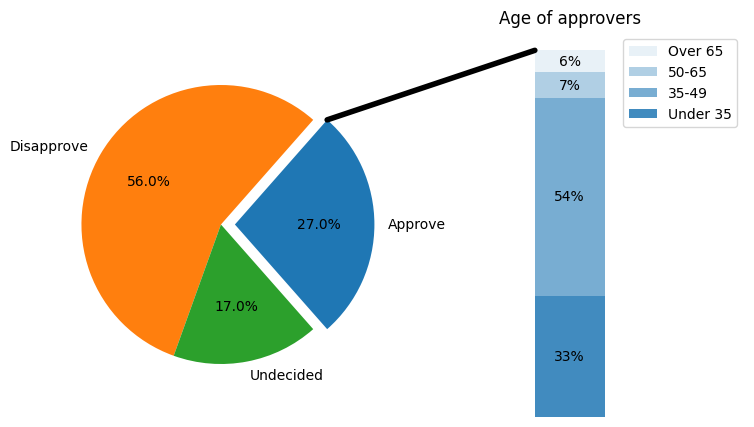

In [105]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]

# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# # draw top connecting line
# x = r * np.cos(np.pi / 180 * theta2) + center[0]
# y = r * np.sin(np.pi / 180 * theta2) + center[1]
# con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
#                       xyB=(x, y), coordsB=ax1.transData)
# con.set_color([0, 0, 0])
# con.set_linewidth(4)
# ax2.add_artist(con)

# # draw bottom connecting line
# x = r * np.cos(np.pi / 180 * theta1) + center[0]
# y = r * np.sin(np.pi / 180 * theta1) + center[1]
# con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
#                       xyB=(x, y), coordsB=ax1.transData)
# con.set_color([0, 0, 0])
# ax2.add_artist(con)
# con.set_linewidth(4)

plt.show()

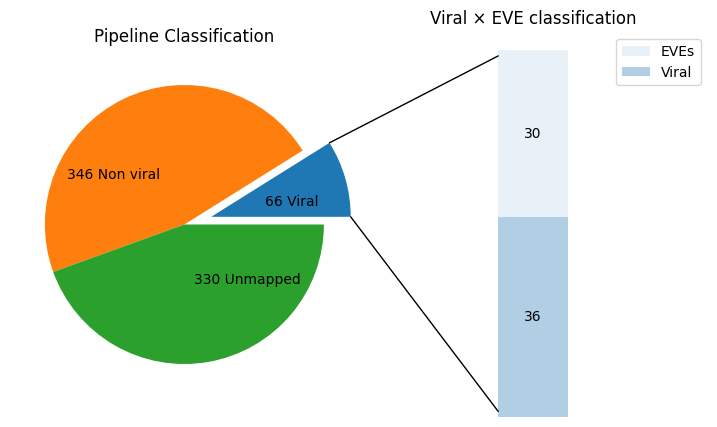

In [130]:

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
foo = [(66, 'Viral'), (346, 'Non viral'), (330, 'Unmapped')]
overall_ratios = [sector[0] for sector in foo]
# labels = ['Viral', 'Non Viral', 'Unmapped']
labels = [F'{sector[0]} {sector[1]}' for sector in foo]
explode = [0.2, 0, 0]

# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
# wedges, *_ = ax1.pie(overall_ratios, labels=labels, autopct='%1.0f%%', explode=explode, startangle=angle)
# wedges, *_ = ax1.pie(overall_ratios, labels=labels, explode=explode, startangle=angle, pctdistance=8.5, labeldistance=1.1)
wedges, *_ = ax1.pie(overall_ratios, labels=labels, explode=explode, startangle=angle, labeldistance=.4)

# bar chart parameters
age_ratios = [36, 30]
age_labels = ['Viral', 'EVEs']
bottom = 1
width = .2

ax1.set_title('Pipeline Classification')

# # Plotting the pie chart with labels inside
# plt.pie(values, labels=sectors, autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1)

# # Drawing a white circle at the center to create a donut chart-like appearance
# center_circle = plt.Circle((0, 0), 0.70, fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(center_circle)


# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label, alpha=0.1 + 0.25 * j)
    # ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    ax2.bar_label(bc, labels=[height], label_type='center')

ax2.set_title('Viral × EVE classification')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(
    xyA=(-width / 2, 0), coordsA=ax2.transData,
    # xyB=(x, y), coordsB=ax1.transData
    xyB=(x, y), coordsB=ax1.transData
)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -64), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

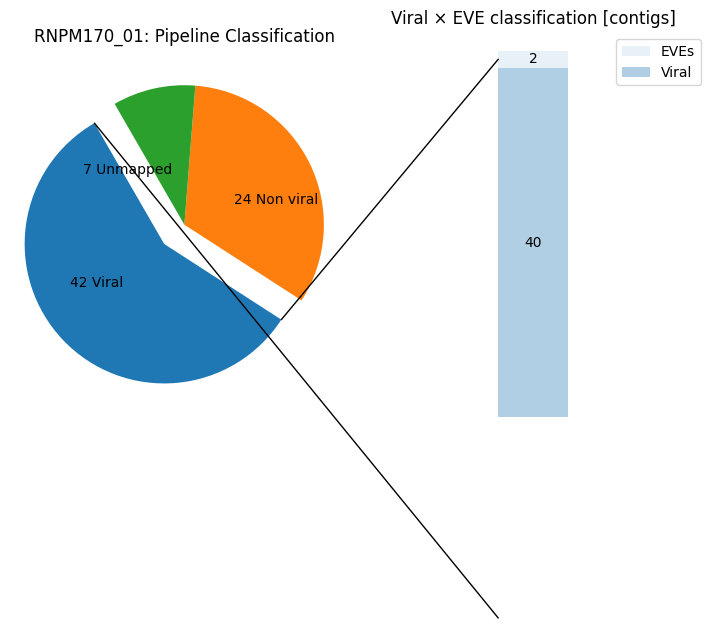

In [30]:

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
foo = [(42, 'Viral'), (24, 'Non viral'), (7, 'Unmapped')]
overall_ratios = [sector[0] for sector in foo]
# labels = ['Viral', 'Non Viral', 'Unmapped']
labels = [F'{sector[0]} {sector[1]}' for sector in foo]
explode = [0.2, 0, 0]

# rotate so that first wedge is split by the x-axis
angle = 20 * overall_ratios[0]
# wedges, *_ = ax1.pie(overall_ratios, labels=labels, autopct='%1.0f%%', explode=explode, startangle=angle)
# wedges, *_ = ax1.pie(overall_ratios, labels=labels, explode=explode, startangle=angle, pctdistance=8.5, labeldistance=1.1)
wedges, *_ = ax1.pie(overall_ratios, labels=labels, explode=explode, startangle=angle, labeldistance=.4)

# bar chart parameters
age_ratios = [40, 2]
age_labels = ['Viral', 'EVEs']
bottom = 1
width = .2

ax1.set_title('RNPM170_01: Pipeline Classification')

# # Plotting the pie chart with labels inside
# plt.pie(values, labels=sectors, autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1)

# # Drawing a white circle at the center to create a donut chart-like appearance
# center_circle = plt.Circle((0, 0), 0.70, fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(center_circle)


# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label, alpha=0.1 + 0.25 * j)
    # ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    ax2.bar_label(bc, labels=[height], label_type='center')

ax2.set_title('Viral × EVE classification [contigs]')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(
    xyA=(-width / 2, 0), coordsA=ax2.transData,
    # xyB=(x, y), coordsB=ax1.transData
    xyB=(x, y), coordsB=ax1.transData
)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -64), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

## Inspect individual lib

In [60]:
# { 'id': 'RNPM169_01',   'dir': f'{path_r2d2}/RNPM169_01' },
# { 'id': 'RNPM170_01',   'dir': f'{path_r2d2}/RNPM170_01' },



lib = libs[8]
lib['id']

'RNPM170_01'

In [13]:
print(f'\n-- '+lib['id']+' Classification Summary --')
lib['df_classification'].groupby(col_class_dark)[col_class_eve].value_counts()


-- RNPM170_01 Classification Summary --


Similarity_label  class
nohit             eve      14
nonviral          eve      24
viral             viral    40
                  eve       2
Name: class, dtype: int64

In [14]:
lib['df_classification'].head()

,Contigs_ID,Similarity_label,class
0,RNPM170_Contig1015_1014,nohit,eve
1,RNPM170_Contig2835_2834,nohit,eve
2,RNPM170_Contig2840_2839,nohit,eve
3,RNPM170_Contig2851_2850,nohit,eve
4,RNPM170_Contig2855_2854,nohit,eve


In [97]:
# lib['df_classification'][ lib['df_classification']['class'] == 'eve']

In [ ]:
profile.bX_RNPM170_Contig2116_2115.publication

bX_RNPM170_Contig2116_2115
bX_RNPM170_Contig2116_2115

>bX_RNPM170_Contig2116_2115 |QRW41912.1 capsid protein [Netjeret virus]	200

### Plot table

In [15]:
from tabulate import tabulate

In [16]:
table = tabulate(lib['df_classification'], headers='keys', tablefmt='fancy_grid')
print(table)

╒════╤══════════════════════════════════════════════════╤════════════════════╤═════════╕
│    │ Contigs_ID                                       │ Similarity_label   │ class   │
╞════╪══════════════════════════════════════════════════╪════════════════════╪═════════╡
│  0 │ RNPM170_Contig1015_1014                          │ nohit              │ eve     │
├────┼──────────────────────────────────────────────────┼────────────────────┼─────────┤
│  1 │ RNPM170_Contig2835_2834                          │ nohit              │ eve     │
├────┼──────────────────────────────────────────────────┼────────────────────┼─────────┤
│  2 │ RNPM170_Contig2840_2839                          │ nohit              │ eve     │
├────┼──────────────────────────────────────────────────┼────────────────────┼─────────┤
│  3 │ RNPM170_Contig2851_2850                          │ nohit              │ eve     │
├────┼──────────────────────────────────────────────────┼────────────────────┼─────────┤
│  4 │ RNPM170_Contig

## Export report

In [17]:
df_export = pd.DataFrame(
    columns = [
        'ID', 'Lib',
        'Input Size [?]', 'Reads [?]',
        'Mounted Contigs', 'Contigs >= 200nt',
        'Viral [1]', 'Non Viral', 'No Hit',
        'Viral / Viral', 'Viral / EVE',
        'Non Viral / Viral', 'Non Viral / EVE',
        'No Hit / Viral', 'No Hit / EVE',
        'Execution Time',
        # 'Output Size'
    ]
)

In [18]:
df_export[
    
]

SyntaxError: invalid syntax (1333578905.py, line 3)

### Plot table

In [ ]:
import matplotlib.pyplot as plt

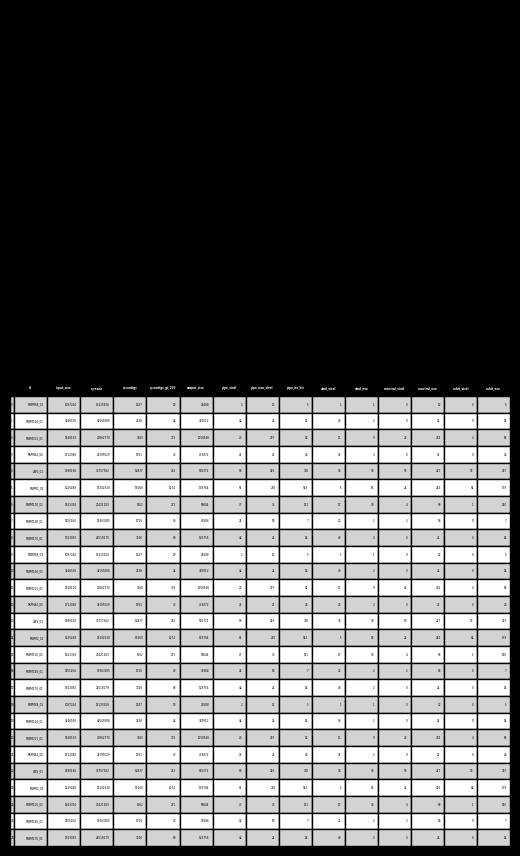

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')  # Hide axis

table = pd.plotting.table(ax, df_report)

# table.auto_set_font_size(False)
# table.scale(2, 1.5)

# Customize table design
for (row, col), cell in table.get_celld().items():
    
    # Header row
    if row == 0:
        cell.set_text_props(size=10, weight='bold', color='white')
        cell.set_facecolor('black')
    
    # Data rows
    else:
        cell.set_text_props(size=10, color='black')
        if row % 2:
            cell.set_facecolor('lightgray')
    
    # # Contig ID column
    # if col == 2:
    #     cell.set_width(1.5)
    # # Other columns
    # else:
    #     cell.set_width(.5)

#
# TODO 23-06-14: Make report files saving worl
#

# path_table = f'{path_root}/{report_name}.png'
# path_table = f'{report_name}.png'
# print(f'path_table: {path_table}')
# plt.savefig(path_table)

plt.show()

# Draft

In [95]:
df_libs_excel = pd.read_excel('/home/hjcosta/Downloads/temp/icb/bibliotecas_hebert.xlsx', sheet_name='Sheet1')
df_libs_excel

,Código,Espécie,Origem da amostra,Ano coleta,Descrição_original,Disponibildiade,Acesso SRA,Descrição,Contaminado
0,RKPM44,Ae. aegypti,Caratinga-MG-Brasil,2011,Mosquitos de campo,Público,SRR14263507,Mosquitos de campo,não
1,RNPM164,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Intestino de mosquitos inffectados com ZIKA em...,Não publicado,NaN,Intestino de mosquitos infectados com ZIKA em ...,sim
2,RNPM169,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcassa de mosquitos inffectados com ZIKA em ...,Não publicado,NaN,Carcaça de mosquitos infectados com ZIKA em la...,sim
3,RNPM170,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcassa de mosquitos inffectados com ZIKA em ...,Não publicado,NaN,Carcaça de mosquitos infectados com ZIKA em la...,sim
4,RNPM68,Ae. albopictus,Montes Claros-MG-Brasil,2017,Mosquitos de campo,Público,SRR14263445,Mosquitos de campo,não
5,RNPM110,Ae. albopictus,Estrasburgo-França,2018,Mosquitos de campo,Público,SRR14263442,Mosquitos de campo,não
6,ZIKV,Ae. japonicus,Lelystad-Holanda,2018,Mosquitos de campo infectato com Zika em labor...,Público,SRR9131262,Mosquitos de campo infectados com Zika em labo...,sim
7,RNPM2,Haemagogus sp.,Brumadinho-MG-Brasil,2017,Mosquito de campo,Não publicado,NaN,Mosquito de campo,não
8,RNPM221,Apis melifera,Viçosa-MG-Brasil,2021,Abelhas coletadas no apiário da Universidade F...,Não publicado,NaN,Abelhas coletadas no apiário da UFV,não


In [101]:
df_excel2 = df_libs_excel.copy()

foo = lambda code: f'{code}_01'

df_excel2['Origem'] = df_excel2['Origem da amostra']
df_excel2['Ano'] = df_excel2['Ano coleta']
df_excel2['Público'] = df_excel2['Disponibildiade'].apply(lambda x: 'sim' if x == 'Público' else 'não')
df_excel2['ID'] = df_excel2['Código'].apply(foo)
# df_excel2[ df_excel2['Código'] == 'RNPM110' ]['ID'] = 'RNPM110_02'
# df_excel2.iloc[5]['ID'] = 'RNPM110_02'

df_excel2.at[5, 'ID'] = 'RKPM44_06'
df_excel2.at[0, 'ID'] = 'RNPM110_02'
df_excel2.at[7, 'ID'] = 'RNPM2_02'

df_excel2.columns
# RNPM169_01	19663205	19.66	02:36:24:331	r2d2	2.606759
# 0	RNPM68_01	13125926	13.13	02:43:15:146	dicer2	2.720874
# 8	RNPM170_01	24518179	24.52	02:57:24:567	r2d2	2.956824
# 1	RNPM164_01	44565086	44.57	03:43:50:482	dicer2	3.730689
# 6	RNPM110_02	20421283	20.42	05:20:44:031	r2d2	5.345564
# 2	RNPM221_01	20062770	20.06	05:39:36:411	dicer2	5.660114
# 4	ZIKV_01	33757362	33.76	09:28:07:815	dicer2	9.468838
# 3	RKPM44_06	21595029	21.60	13:17:46:144	dicer2	13.296151
# 5	RNPM2_02

# df_excel2


pumba = [
    'ID',
    # 'Código', 
    'Espécie', 
    'Origem', 
    # 'Origem da amostra', 
    # 'Ano coleta', 
    'Ano', 
    'Descrição',
    # 'Disponibildiade',
    'Público',
    # 'Acesso SRA',
    'Contaminado',
]


    
df_excel2[pumba]

,ID,Espécie,Origem,Ano,Descrição,Público,Contaminado
0,RNPM110_02,Ae. aegypti,Caratinga-MG-Brasil,2011,Mosquitos de campo,sim,não
1,RNPM164_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Intestino de mosquitos infectados com ZIKA em ...,não,sim
2,RNPM169_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcaça de mosquitos infectados com ZIKA em la...,não,sim
3,RNPM170_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcaça de mosquitos infectados com ZIKA em la...,não,sim
4,RNPM68_01,Ae. albopictus,Montes Claros-MG-Brasil,2017,Mosquitos de campo,sim,não
5,RKPM44_06,Ae. albopictus,Estrasburgo-França,2018,Mosquitos de campo,sim,não
6,ZIKV_01,Ae. japonicus,Lelystad-Holanda,2018,Mosquitos de campo infectados com Zika em labo...,sim,sim
7,RNPM2_02,Haemagogus sp.,Brumadinho-MG-Brasil,2017,Mosquito de campo,não,não
8,RNPM221_01,Apis melifera,Viçosa-MG-Brasil,2021,Abelhas coletadas no apiário da UFV,não,não


In [106]:

new_df = pd.merge(df_report2, df_excel2, on='ID', how='inner')
# new_df.sort_values(by='ID')
new_df

# 	ID	viral	nonviral	nohit	viral [viral]	viral [eve]	nonviral [viral]	nonviral [eve]	nohit [viral]	nohit [eve]
# 0	RNPM68_01	2	12	5	1	1	0	12	0	5
# 1	RNPM164_01	42	24	14	40	2	0	24	0	14
# 2	RNPM221_01	20	297	62	11	9	23	274	4	58
# 3	RKPM44_06	25	21	26	23	2	0	21	0	26
# 4	ZIKV_01	66	346	330	36	30	99	247	93	237
# 5	RNPM2_02	61	270	943	5	56	24	246	64	879
# 6	RNPM110_02	47	73	151	17	30	4	69	1	150
# 7	RNPM169_01	24	18	7	22	2	2	16	0	7
# 8	RNPM170_01	42	24	14	40	2	0	24	0	14

,ID,Reads,Contigs,Contigs >= 200nt,viral,nonviral,nohit,viral [viral],viral [eve],nonviral [viral],...,Origem da amostra,Ano coleta,Descrição_original,Disponibildiade,Acesso SRA,Descrição,Contaminado,Origem,Ano,Público
0,RNPM68_01,13125926,1247,19,2,12,5,1,1,0,...,Montes Claros-MG-Brasil,2017,Mosquitos de campo,Público,SRR14263445,Mosquitos de campo,não,Montes Claros-MG-Brasil,2017,sim
1,RNPM164_01,44565086,2138,44,42,24,14,40,2,0,...,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Intestino de mosquitos inffectados com ZIKA em...,Não publicado,NaN,Intestino de mosquitos infectados com ZIKA em ...,sim,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,não
2,RNPM221_01,20062770,3560,379,20,297,62,11,9,23,...,Viçosa-MG-Brasil,2021,Abelhas coletadas no apiário da Universidade F...,Não publicado,NaN,Abelhas coletadas no apiário da UFV,não,Viçosa-MG-Brasil,2021,não
3,RKPM44_06,21595029,1991,73,25,21,26,23,2,0,...,Estrasburgo-França,2018,Mosquitos de campo,Público,SRR14263442,Mosquitos de campo,não,Estrasburgo-França,2018,sim
4,ZIKV_01,33757362,12837,742,66,346,330,36,30,99,...,Lelystad-Holanda,2018,Mosquitos de campo infectato com Zika em labor...,Público,SRR9131262,Mosquitos de campo infectados com Zika em labo...,sim,Lelystad-Holanda,2018,sim
5,RNPM2_02,15102630,19160,1274,61,270,943,5,56,24,...,Brumadinho-MG-Brasil,2017,Mosquito de campo,Não publicado,NaN,Mosquito de campo,não,Brumadinho-MG-Brasil,2017,não
6,RNPM110_02,20421283,5562,271,47,73,151,17,30,4,...,Caratinga-MG-Brasil,2011,Mosquitos de campo,Público,SRR14263507,Mosquitos de campo,não,Caratinga-MG-Brasil,2011,sim
7,RNPM169_01,19663205,1716,49,24,18,7,22,2,2,...,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcassa de mosquitos inffectados com ZIKA em ...,Não publicado,NaN,Carcaça de mosquitos infectados com ZIKA em la...,sim,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,não
8,RNPM170_01,24518179,3166,80,42,24,14,40,2,0,...,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,Carcassa de mosquitos inffectados com ZIKA em ...,Não publicado,NaN,Carcaça de mosquitos infectados com ZIKA em la...,sim,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,não


In [117]:
pumba = [
    'ID',
    # 'Código', 
    'Espécie', 
    'Origem', 
    # 'Origem da amostra', 
    # 'Ano coleta', 
    'Ano', 
    # 'Disponibildiade',
    # 'Acesso SRA',
    'Contaminado',
    'Público',
    # 'Descrição',
]


foo = lambda x: x*'-'
baz = f'{foo(19)}'
print(f'--  {baz} Bibliotecas utilizadas em cada experimento  {baz}')

new_df[pumba]

--  ------------------- Bibliotecas utilizadas em cada experimento  -------------------


,ID,Espécie,Origem,Ano,Contaminado,Público
0,RNPM68_01,Ae. albopictus,Montes Claros-MG-Brasil,2017,não,sim
1,RNPM164_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,sim,não
2,RNPM221_01,Apis melifera,Viçosa-MG-Brasil,2021,não,não
3,RKPM44_06,Ae. albopictus,Estrasburgo-França,2018,não,sim
4,ZIKV_01,Ae. japonicus,Lelystad-Holanda,2018,sim,sim
5,RNPM2_02,Haemagogus sp.,Brumadinho-MG-Brasil,2017,não,não
6,RNPM110_02,Ae. aegypti,Caratinga-MG-Brasil,2011,não,sim
7,RNPM169_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,sim,não
8,RNPM170_01,Ae. aegypti,Linhagem de labaoratório. RNAI-ICB-UFMG,2021,sim,não
